In [ ]:
!pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.table as tab
from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
# all companies list
all_list = []
all_list.append(pd.read_csv("https://www1.nseindia.com/content/indices/ind_nifty100list.csv")["Symbol"].tolist())
all_list.append(pd.read_csv("https://www1.nseindia.com/content/indices/ind_niftymidcap100list.csv")["Symbol"].tolist())
all_list.append(pd.read_csv("https://www1.nseindia.com/content/indices/ind_niftysmallcap50list.csv")["Symbol"].tolist())

full_data_dict = {}
lcap_dict = {}
mcap_dict = {}
scap_dict = {}

for index, li in enumerate(all_list):
    for ticker in li:
        info = yf.Ticker(ticker + ".NS")

        if info.info is None:
            print(f"data not found for {ticker}")
            continue

        if index == 0:
            lcap_dict[ticker] = info.info
        elif index == 1:
            mcap_dict[ticker] = info.info
        else:
            scap_dict[ticker] = info.info

        full_data_dict[ticker] = info.info
        print(ticker+' done')
        if len(full_data_dict)%5 == 0:
            break

print(full_data_dict)
print(lcap_dict)
print(mcap_dict)
print(scap_dict)



In [ ]:
columns=['shortName', 'sector', 'industry', 'marketCap']
fdf = pd.DataFrame.from_dict(full_data_dict, orient='index', columns=columns)
ldf = pd.DataFrame.from_dict(lcap_dict, orient='index', columns=columns)
mdf = pd.DataFrame.from_dict(mcap_dict, orient='index', columns=columns)
sdf = pd.DataFrame.from_dict(scap_dict, orient='index', columns=columns)

In [ ]:
# for i in range(len(df["sector"])):
#     print(df["marketCap"][i])
# df.marketCap.mean()

In [ ]:
def get_total_market_cap(df, on):
    """extract/prepares x, y axies data"""
    total_sector_market_cap = {}
    sector_market_cap = {}
    for i in range(len(df[on])):
        if df[on][i] in sector_market_cap:
            total_sector_market_cap[df[on][i]] = total_sector_market_cap[df[on][i]]+df["marketCap"][i]
            continue
        sector_market_cap[df[on][i]] = True
        total_sector_market_cap[df[on][i]] = df["marketCap"][i]
    return total_sector_market_cap

In [ ]:
def currency(x, pos):
    """convert raw currency to crores format"""
    if x >= 1e7:
        s = '{:1.1f}cr'.format(x*1e-7)
    elif x >= 1e6:
        s = '{:1.2f}cr'.format(x*1e-7)
    else:
        s = '{:1.2f}cr'.format(x*1e-6)
    return s

In [ ]:
def style():
  plt.style.use('fivethirtyeight')
  plt.rcParams.update({'figure.autolayout': True})

In [ ]:
def barh(x, y, l, s):
    """plots given x, y in bar chart and table contain details"""
    fig, ax = plt.subplots(figsize=s)
    fig.tight_layout(pad=4)
    # fig.suptitle("Smallcap Stocks", va="bottom")
    # plot horizontal bar graph
    ax.barh(x, y, 0.5)
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=45, horizontalalignment='right')
    # set labels
    ax.set(xlabel=l["x"], ylabel=l["y"], title=l["t"])
    # format to crores
    ax.xaxis.set_major_formatter(plt.FuncFormatter(currency))
    # Add a vertical line, here we set the style in the function call
    ax.axvline(np.mean(y), ls='--', color='r', label=f"mean {currency(x=np.mean(y), pos=None)}")
    ax.axvline(15000*1e7, ls='--', color='y', label=f"mid cap {15000}cr")
    ax.axvline(50000*1e7, ls='--', color='g', label=f"large cap {50000}cr")
    ax.legend()
    # Annotate market cap for each bar
    for p in ax.patches:
        ax.annotate("{}".format(currency(x=p.get_width(), pos="")), xy=(p.get_width()+0.12, p.get_y()+0.12))

In [ ]:
def table(df):
    df["marketCap"] = [currency(x=a, pos=None) for a in df["marketCap"]]
    print(df)
    #hide the axes
    fig, ax = plt.subplots(figsize=(12, (len(df.values)/2)-5))
    fig.tight_layout(pad=4)
    ax.axis('off')
    ax.axis('tight')
    ax.set(title="Smallcap Top 50")
    #create table
    table = tab.table(ax, cellText=df.values, colLabels=df.columns, loc='center',
              cellLoc="center", colColours=["orange"]*len(df.columns))
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(0, 2)
    table.auto_set_column_width(col=list(range(len(df.columns))))
    ax.add_table(table)

In [ ]:
def save(filename):
    pp = PdfPages(filename)
    fig_nums = plt.get_fignums()
    figs = [plt.figure(n) for n in fig_nums]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()
  

In [ ]:
def process(df, st, it, tt, filename):
    # prepare style
    style()

    # plots sectors vs market captial
    sector_details = get_total_market_cap(df=df, on="sector")
    barh(list(sector_details.keys()), list(sector_details.values()),
        {"x":"Market capital", "y":"Sector", "t":"sector vs market cap"},
        st)

    # plots industries vs market captial
    industry_details = get_total_market_cap(df=df, on="industry")
    barh(list(industry_details.keys()), list(industry_details.values()),
        {"x":"Market capital", "y":"Industry", "t":"industry vs market cap"},
        it)

    # plot details in table
    # table(df)

    # save all figure into single pdf
    save(filename)

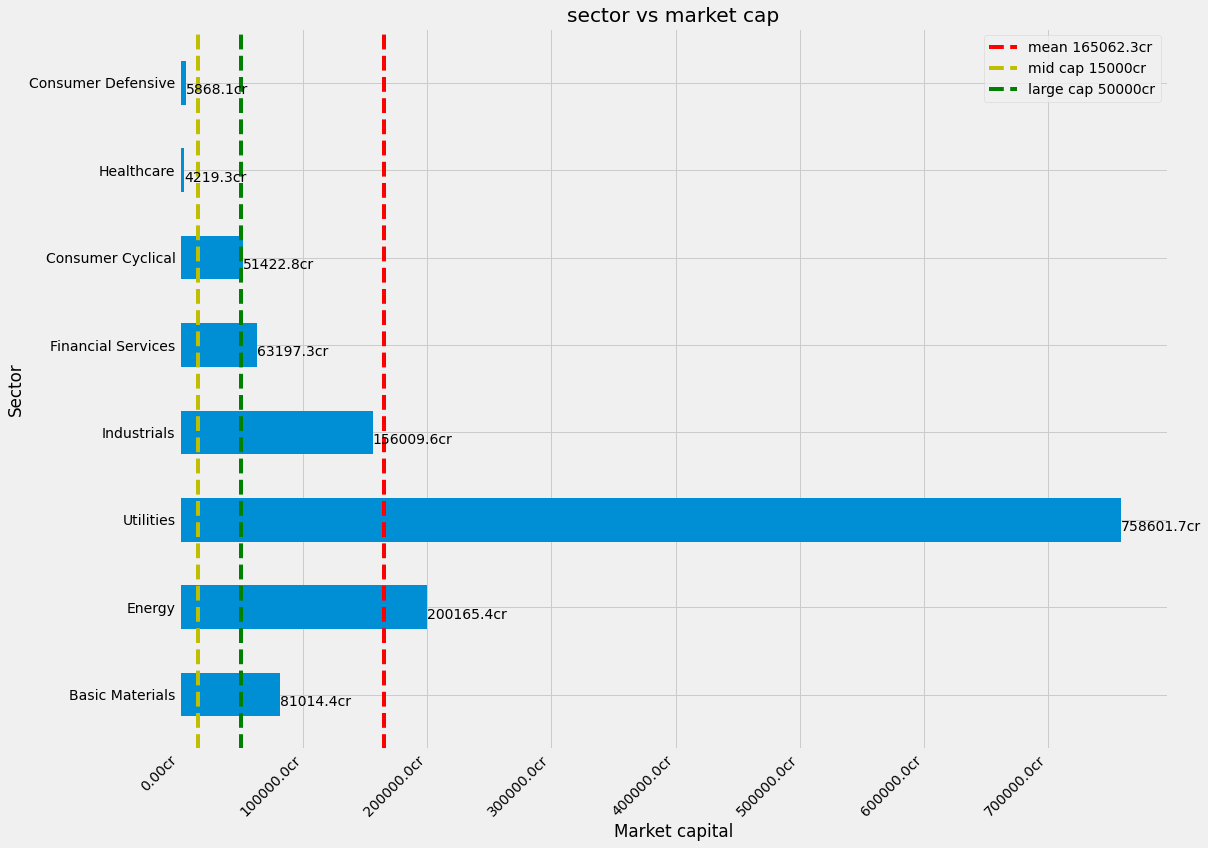

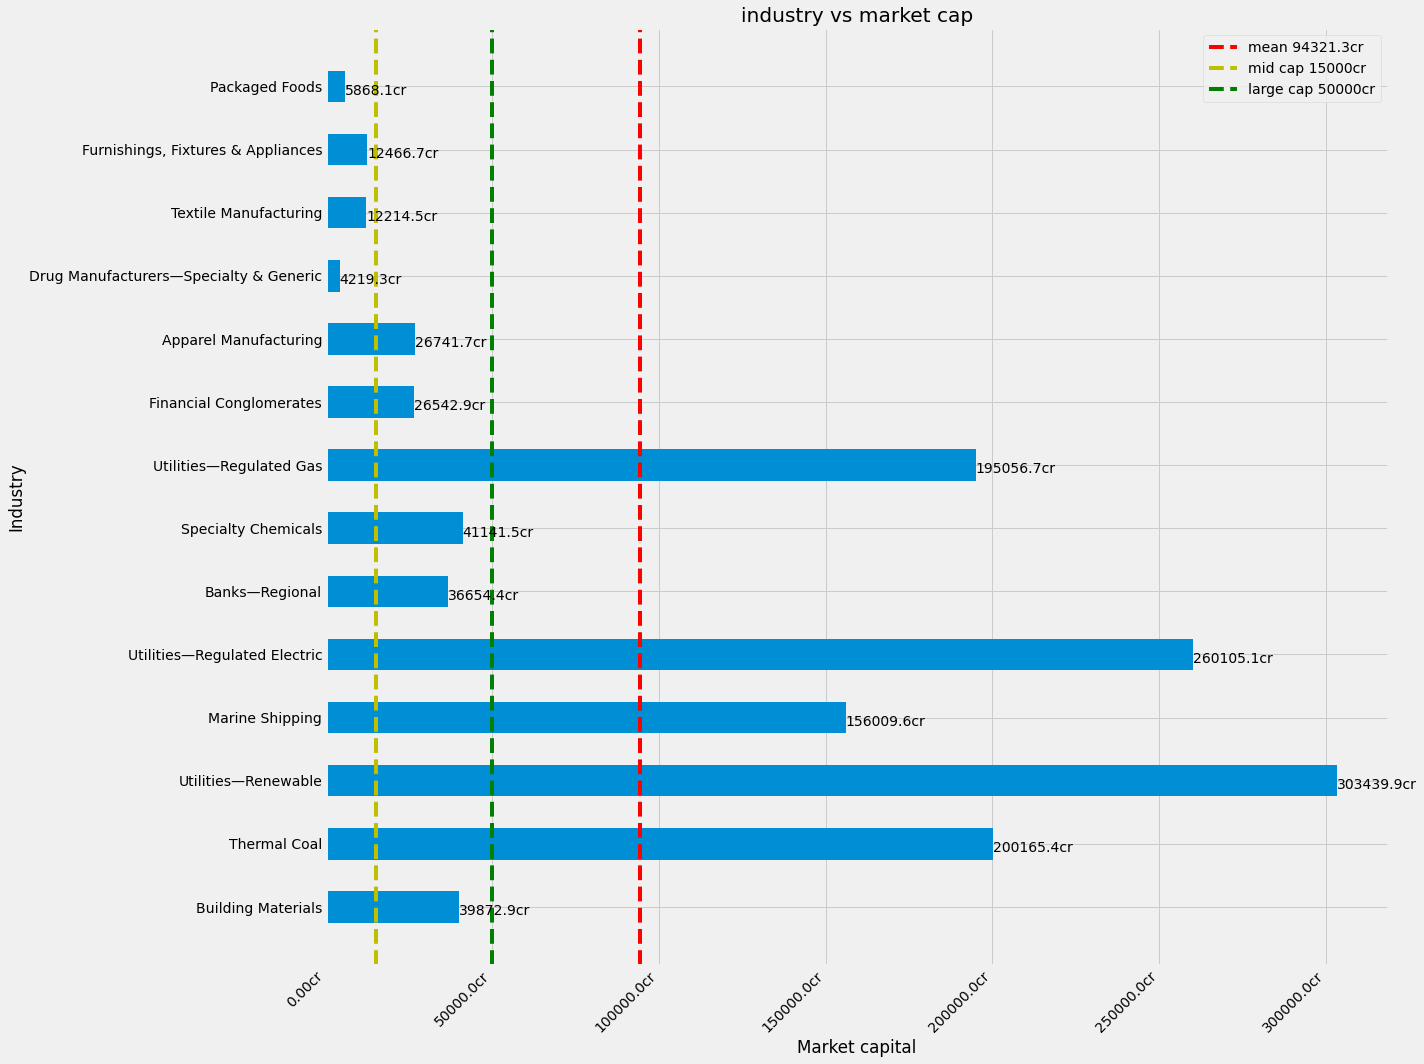

In [ ]:
# process(sdf, (12, 7), (15, 10), None, "smallcap50.pdf")
# process(mdf, (15, 10), (17, 12), None, "midcap100.pdf")
# process(ldf, (15, 10), (17, 12), None, "largecap100.pdf")
process(fdf, (17, 12), (20, 15), None, "allcap250.pdf")